# Threegram Language Model

Solution to exercises proposed in [1].


**References:**

[1] [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo&t=3082s&ab_channel=AndrejKarpathy)

**Exercises:**

1. *Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?*

2.  *Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?*


3. *Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?*

4. *We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?*

5. *Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?*

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [1]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-11-27 10:55:58--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.006s  

2022-11-27 10:55:58 (36.6 MB/s) - ‘names.txt’ saved [228145/228145]



## 1. *Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?*

### Approach 1: weight matrix $w$ of shape (27 + 27, 27)

**Compute three grams**

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}

In [7]:
def build_three_grams(words):
    x, y = [], []

    for w in words:
        # print(f"word: {w}\n")
        chs = ".." + w + "."
        for idx in range(0, len(chs) - 2):
            ch1, ch2, ch3 = chs[idx: idx + 2 + 1]
            # print(f"{ch1}{ch2}-> {ch3}")
            idx1, idx2, idx3 = stoi[ch1], stoi[ch2], stoi[ch3] 

            x.append([idx1, idx2])
            y.append(idx3)

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

In [8]:
x, y = build_three_grams(words)

**One-hot encode the x tensor**

In [9]:
# One hot encode the first character
x1 = x[:, 0]
# One hot encode the second character
x2 = x[:, 1]

In [10]:
for i in range(12):
    print(f"{itos[x1[i].item()]}{itos[x2[i].item()]}-> {itos[y[i].item()]}")

..-> e
.e-> m
em-> m
mm-> a
ma-> .
..-> o
.o-> l
ol-> i
li-> v
iv-> i
vi-> a
ia-> .


In [11]:
x1_enc = F.one_hot(x1, num_classes=27).float()
x1_enc.shape

torch.Size([228146, 27])

In [13]:
x2_enc = F.one_hot(x2, num_classes=27).float()
x2_enc.shape

torch.Size([228146, 27])

In [14]:
x_enc = torch.cat((x1_enc, x2_enc), dim=1)
x_enc.shape

torch.Size([228146, 54])

**Build the Linear MLP.**

In [15]:
input_dim = x_enc.shape[1]
output_dim = 27

w = torch.randn((input_dim, output_dim), requires_grad=True)
w.shape

torch.Size([54, 27])

In [23]:
x_enc_i = x_enc[12]
x_enc_i = torch.tensor([x_enc_i.tolist()])
x_enc_i

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
# forward-pass
logits = x_enc_i @ w # predict log-counts
counts = logits.exp()
probas = counts / counts.sum(1, keepdims=True)
probas

tensor([[0.1044, 0.1183, 0.0196, 0.0109, 0.0177, 0.2708, 0.0163, 0.0367, 0.0085,
         0.0229, 0.0046, 0.0058, 0.0123, 0.0033, 0.0202, 0.0086, 0.0085, 0.1601,
         0.0131, 0.0048, 0.0058, 0.0035, 0.0247, 0.0186, 0.0602, 0.0129, 0.0068]],
       grad_fn=<DivBackward0>)

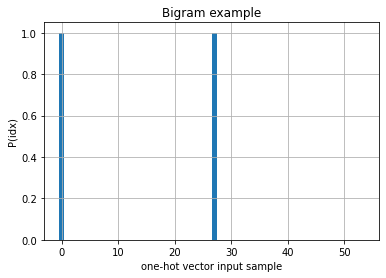

In [32]:
plt.bar(range(54), x_enc_i[0])
plt.xlabel("one-hot vector input sample")
plt.ylabel("P(idx)")
plt.title("Bigram example")
plt.grid()

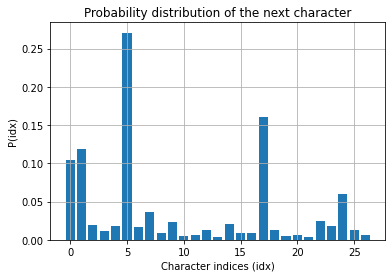

In [30]:
plt.bar(range(27), probas[0].tolist())
plt.xlabel("Character indices (idx)")
plt.ylabel("P(idx)")
plt.title("Probability distribution of the next character")
plt.grid()

**Train the network**

train_loss (final): 2.356121063232422


[]

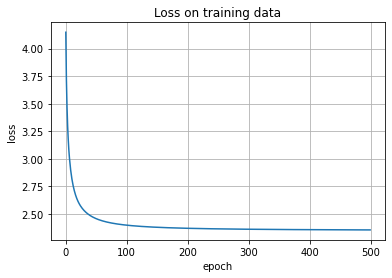

In [34]:
import torch.nn.functional as F

N_ITERS = 500
LEARN_RATE = 25
C = 0.01
losses = []


w = torch.randn((input_dim, output_dim), requires_grad=True)

for k in range(N_ITERS):
    # Forward pass
    logits = x_enc @ w # predict log-counts
    counts = logits.exp()
    probas = counts / counts.sum(1, keepdims=True)

    # Compute loss (apply regularization)
    loss = -1 * probas[torch.arange(x_enc.shape[0]), y].log().mean() + C * (w ** 2).mean()
    # print(f"loss: {loss.data}")
    losses.append(loss.data)

    # Zero grads and do backwards pass
    w.grad = None
    loss.backward()

    # Update model weights
    w.data = w.data - LEARN_RATE * w.grad

print(f"train_loss (final): {losses[-1]}")
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid() 
plt.plot()

**Generated words**

In [35]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    sampled_idxs = [0, 0]
    generated_names = []

    while True:
        # Get the probability distribution of the next character given a set of two characters
        # One-hot encode
        x1_enc = F.one_hot(torch.tensor([sampled_idxs[0]]), num_classes=27).float() 
        x2_enc = F.one_hot(torch.tensor([sampled_idxs[1]]), num_classes=27).float() 
        x_enc = torch.cat((x1_enc, x2_enc), dim=1)

        logits = x_enc @ w
        counts = logits.exp()
        p_dist = counts / counts.sum(1, keepdims=True)

        sampled_idxs[0] = sampled_idxs[1]
        sampled_idxs[1] = torch.multinomial(p_dist, num_samples=1, replacement=True, generator=g).item()
        
        generated_names.append(itos[sampled_idxs[1]])

        if sampled_idxs[1] == 0:
            break

    print("generated_names:", "".join(generated_names))

generated_names: mor.
generated_names: ays.
generated_names: minaymnnyadraisemiaclah.
generated_names: arilyeny.
generated_names: rie.
generated_names: oi.
generated_names: ondalaek.
generated_names: shalekirierielah.
generated_names: yshi.
generated_names: haat.


### Approach 2: weight matrix $w$ of shape (720, 27)

In [36]:
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}

In [47]:
from itertools import product

chars_copy = chars.copy()
chars_copy.append(".")

chars2 = set()
for comb in product(chars_copy, repeat=2):
    chars2.add("".join(comb))

chars2 = sorted(list(chars2))
len(chars2)

729

In [48]:
stoi2 = {s:idx + 1 for idx, s in enumerate(chars2)}
stoi2[".."] = 0
itos2 = {idx: s for s, idx in stoi2.items()}

In [54]:
def build_three_grams(words):
    x, y = [], []

    for w in words:
        # print(f"word: {w}\n")
        chs = ".." + w + "."
        for idx in range(0, len(chs) - 2):
            ch1, ch2, ch3 = chs[idx: idx + 2 + 1]
            # print(f"{ch1}{ch2}-> {ch3}")
            idx1, idx2 = stoi2[ch1 + ch2], stoi[ch3] 

            x.append(idx1)
            y.append(idx2)

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

In [55]:
x, y = build_three_grams(words)

In [58]:
x[0]

tensor(0)

**One-hot encode the x tensor**

In [62]:
x.max()

tensor(729)

In [65]:
x_enc = F.one_hot(x, num_classes=len(chars2) + 1).float()
x_enc.shape

torch.Size([228146, 730])

**Build the Linear MLP.**

In [66]:
input_dim = x_enc.shape[1]
output_dim = 27

w = torch.randn((input_dim, output_dim), requires_grad=True)
w.shape

torch.Size([730, 27])

In [88]:
x_enc_i = x_enc[43]
x_enc_i = torch.tensor([x_enc_i.tolist()])
x_enc_i.shape

torch.Size([1, 730])

In [89]:
# forward-pass
logits = x_enc_i @ w # predict log-counts
counts = logits.exp()
probas = counts / counts.sum(1, keepdims=True)
probas

tensor([[0.0662, 0.0086, 0.0061, 0.0035, 0.0434, 0.0560, 0.1047, 0.0050, 0.0084,
         0.0362, 0.0411, 0.0294, 0.0238, 0.0321, 0.0072, 0.0067, 0.0112, 0.0866,
         0.0035, 0.0166, 0.0264, 0.0068, 0.0094, 0.1350, 0.1949, 0.0120, 0.0190]],
       grad_fn=<DivBackward0>)

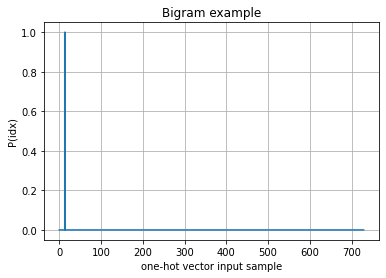

In [90]:
plt.step(range(730), x_enc_i[0])
plt.xlabel("one-hot vector input sample")
plt.ylabel("P(idx)")
plt.title("Bigram example")
plt.grid()

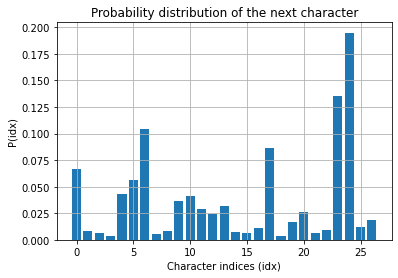

In [91]:
plt.bar(range(27), probas[0].tolist())
plt.xlabel("Character indices (idx)")
plt.ylabel("P(idx)")
plt.title("Probability distribution of the next character")
plt.grid()

**Train the network**

train_loss (final): 2.3597261905670166


[]

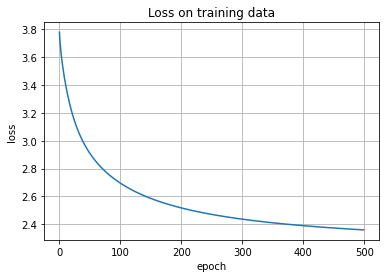

In [92]:
import torch.nn.functional as F

N_ITERS = 500
LEARN_RATE = 25
C = 0.01
losses = []


w = torch.randn((input_dim, output_dim), requires_grad=True)

for k in range(N_ITERS):
    # Forward pass
    logits = x_enc @ w # predict log-counts
    counts = logits.exp()
    probas = counts / counts.sum(1, keepdims=True)

    # Compute loss (apply regularization)
    loss = -1 * probas[torch.arange(x_enc.shape[0]), y].log().mean() + C * (w ** 2).mean()
    # print(f"loss: {loss.data}")
    losses.append(loss.data)

    # Zero grads and do backwards pass
    w.grad = None
    loss.backward()

    # Update model weights
    w.data = w.data - LEARN_RATE * w.grad

print(f"train_loss (final): {losses[-1]}")
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid() 
plt.plot()

**Generated words**

In [186]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    idx = 0
    generated_names = []

    i = 0
    while True:
        # Get the probability distribution of the next character given a set of two characters
        # print(f"Predicting next chars using: {itos2[idx]} ")
        
        # One-hot encode
        x_enc = F.one_hot(torch.tensor([idx]), num_classes=730).float()

        # Make a prediction
        logits = x_enc @ w
        counts = logits.exp()
        p_dist = counts / counts.sum(1, keepdims=True)

        # Sample from the probability distribution
        sampled_idx = torch.multinomial(p_dist, num_samples=1, replacement=True, generator=g).item()
        generated_names.append(itos[sampled_idx])
        # print(f"Predicted char: {itos[sampled_idx]}")
        
        idx = stoi2[itos2[idx][-1] + itos[sampled_idx]]

        if sampled_idx == stoi["."]:
            break

    print("generated_names:", "".join(generated_names))

generated_names: mknbaytcppnjxrutyn.
generated_names: salon.
generated_names: oder.
generated_names: el.
generated_names: marwiny.
generated_names: ron.
generated_names: odarimalabelon.
generated_names: hamirelsona.
generated_names: elyn.
generated_names: rae.
generated_names: bra.
generated_names: cdhypfhqjqgordria.
generated_names: miki.
generated_names: ai.
generated_names: fa.
generated_names: jijhon.
generated_names: axtyraliefqrsya.
generated_names: zadtislihan.
generated_names: kryn.
generated_names: yushainelleerlourenn.


**Comment:** It seems like both approaches yield the roughly the same result, however the second approach takes longer to train (since the input tensors are larger).

Why both (seem to) work ?

In approach 1 we use the one hot encoded input vector (x_enc_i) to index two rows in the $w$ matrix, the resulting vector (y_hat_i) is just the sum of this two rows. We optimize the weights of $w$ s.t the sum of two indexed rows matches the distribution of the label vector as much as possible.

In approach 2 we use one hot encoded vector to index just one row in the $w$ matrix and then optimize the index row to match the distribution of label vector.


I decided to stick with the second approach for the rest of the exercises.

## 2.  *Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?*

In [121]:
m = x.shape[0]
m

228146

In [122]:
# compute random indices.
rand_idxs = torch.randperm(m)
# shuffle the data.
x = x[rand_idxs]
y = y[rand_idxs]

x_train = x[: int(0.8 * m)]
y_train = y[: int(0.8 * m)]
x_val = x[int(0.8 * m): int(0.9 * m)]
y_val = y[int(0.8 * m): int(0.9 * m)]
x_test = x[int(0.9 * m):]
y_test = y[int(0.9 * m):]

In [123]:
x_train_enc = F.one_hot(x_train, num_classes=len(chars2) + 1).float()
x_val_enc = F.one_hot(x_val, num_classes=len(chars2) + 1).float()
x_test_enc = F.one_hot(x_test, num_classes=len(chars2) + 1).float()

**Train again this time also reporting the validation loss.**

In [ ]:
import torch.nn.functional as F

N_ITERS = 200
LEARN_RATE = 100
C = 0.01
train_losses = []
val_losses = []

w = torch.randn((input_dim, output_dim), requires_grad=True)

for k in range(N_ITERS):
    # Forward pass
    logits = x_train_enc @ w # predict log-counts
    counts = logits.exp()
    probas = counts / counts.sum(1, keepdims=True)

    # Compute loss (apply regularization)
    train_loss = -1 * probas[torch.arange(x_train_enc.shape[0]), y_train].log().mean() + C * (w ** 2).mean()
    print(f"loss: {train_loss.data}")
    train_losses.append(train_loss.data)

    with torch.no_grad():
        logits_val = x_val_enc @ w # predict log-counts
        counts_val = logits_val.exp()
        probas_val = counts_val / counts_val.sum(1, keepdims=True)
        val_loss = -1 * probas_val[torch.arange(x_val_enc.shape[0]), y_val].log().mean()
        val_losses.append(val_loss)

    # Zero grads and do backwards pass
    w.grad = None
    train_loss.backward()

    # Update model weights
    w.data = w.data - LEARN_RATE * w.grad

In [194]:
print(train_losses[-1])

tensor(2.3062)


[]

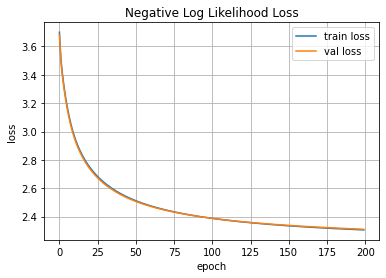

In [140]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Negative Log Likelihood Loss")
plt.legend()
plt.grid()
plt.plot()

**Comment**: It seems like the model is slightly underfitting, since the train loss is not lower than validation loss.

## 3. *Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?*

In [189]:
import torch.nn.functional as F
from tqdm import tqdm

N_ITERS = 200
LEARN_RATE = 100
reg_stenghts = [0, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 1.0]

w = torch.randn((input_dim, output_dim), requires_grad=True)
loss_dict = {} # <reg_strength: [final train loss, final val loss]>

for reg_strength in tqdm(reg_stenghts):
    # Init model and losses.
    w = torch.randn((input_dim, output_dim), requires_grad=True)
    train_losses = []
    val_losses = []

    for k in range(N_ITERS):
        # Forward pass
        logits = x_train_enc @ w # predict log-counts
        counts = logits.exp()
        probas = counts / counts.sum(1, keepdims=True)

        # Compute loss (apply regularization)
        train_loss = -1 * probas[torch.arange(x_train_enc.shape[0]), y_train].log().mean() + reg_strength * (w ** 2).mean()
        train_losses.append(train_loss.data)
        # print(f"loss: {train_loss.data}")

        with torch.no_grad():
            logits_val = x_val_enc @ w # predict log-counts
            counts_val = logits_val.exp()
            probas_val = counts_val / counts_val.sum(1, keepdims=True)
            val_loss = -1 * probas_val[torch.arange(x_val_enc.shape[0]), y_val].log().mean()
            val_losses.append(val_loss)

        # Zero grads and do backwards pass
        w.grad = None
        train_loss.backward()

        # Update model weights
        w.data = w.data - LEARN_RATE * w.grad

    print(train_losses[-1], val_losses[-1])
    loss_dict[reg_strength] = [train_losses[-1], val_losses[-1]]
    # plt.figure(figsize=(12, 10))
    # plt.plot(train_losses, label="train loss")
    # plt.plot(val_losses, label="val loss")
    # plt.xlabel("epoch")
    # plt.ylabel("loss")
    # plt.title(f"Negative Log Likelihood Loss, using regularization strenght of: {reg_strength}")
    # plt.legend()
    # plt.grid() 
    # plt.plot()

 12%|█▎        | 1/8 [04:17<29:59, 257.07s/it]

tensor(2.2962) tensor(2.3111)


 25%|██▌       | 2/8 [08:30<25:30, 255.11s/it]

tensor(2.3061) tensor(2.3117)


 38%|███▊      | 3/8 [12:43<21:11, 254.20s/it]

tensor(2.3159) tensor(2.3089)


 50%|█████     | 4/8 [16:57<16:56, 254.10s/it]

tensor(2.3459) tensor(2.3109)


 62%|██████▎   | 5/8 [21:12<12:42, 254.12s/it]

tensor(2.3834) tensor(2.3174)


 75%|███████▌  | 6/8 [25:26<08:28, 254.07s/it]

tensor(2.4499) tensor(2.3219)


 88%|████████▊ | 7/8 [29:38<04:13, 253.68s/it]

tensor(2.4993) tensor(2.3461)


100%|██████████| 8/8 [33:51<00:00, 253.99s/it]

tensor(2.5623) tensor(2.4015)


[]

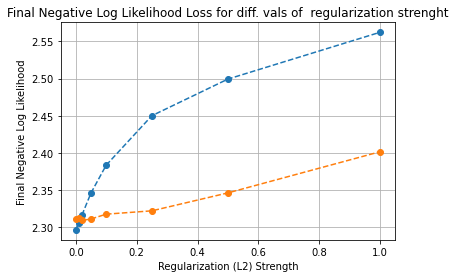

In [192]:
plt.title(f"Final Negative Log Likelihood Loss for diff. vals of  regularization strenght")
plt.plot(list(loss_dict.keys()), [train_loss for train_loss, _ in loss_dict.values()], "o--")
plt.plot(list(loss_dict.keys()), [val_loss for _, val_loss in loss_dict.values()], "o--")
plt.xlabel("Regularization (L2) Strength")
plt.ylabel("Final Negative Log Likelihood")
plt.grid()
plt.plot()

**Comment:** We see that as we increase the regularization strength the loss on the training set increases, the loss on the validation set initially decreases (which is what we expect), but than it also starts increasing

In [196]:
logits_test = x_test_enc @ w # predict log-counts
counts_test = logits_test.exp()
probas_test = counts_test / counts_test.sum(1, keepdims=True)
val_loss = -1 * probas_test[torch.arange(x_test_enc.shape[0]), y_test].log().mean()
val_loss.item()

2.3192195892333984

## 4. *We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?*

Currently we are indexing rows by performing the following matrix multiplication.

```
logits = x_enc_i @ w
logits = [0, 1, 0, 0, ...] @ w
logits = w[1, :]
```

Same could be achivied by simply using the value of x_i as the index of the W matrix:

`logits = w[x_i, :]` 

In [149]:
x_enc = F.one_hot(x, num_classes=len(chars2) + 1).float()
x_enc

tensor(37)

In [150]:
x_enc_i = torch.tensor([x_enc[132].tolist()])
x_enc_i.argmax()

tensor(21)

In [151]:
x_enc_i @ w

tensor([[-1.0152,  3.7219, -0.5428, -2.0982, -0.9418,  2.9426, -1.6451, -0.5537,
          2.2707,  2.2972, -1.2160, -1.3562, -0.6507, -0.3600, -1.3089,  2.3488,
         -0.6095, -0.9302,  2.9562, -1.5573, -1.2926,  0.3976, -1.4667, -0.4334,
         -0.6487,  2.6209, -0.1689]], grad_fn=<MmBackward0>)

In [152]:
x_i = x[132]
x_i

tensor(21)

In [153]:
w[x_i, :]

tensor([-1.0152,  3.7219, -0.5428, -2.0982, -0.9418,  2.9426, -1.6451, -0.5537,
         2.2707,  2.2972, -1.2160, -1.3562, -0.6507, -0.3600, -1.3089,  2.3488,
        -0.6095, -0.9302,  2.9562, -1.5573, -1.2926,  0.3976, -1.4667, -0.4334,
        -0.6487,  2.6209, -0.1689], grad_fn=<SliceBackward0>)

**Predictions for the whole dataset**

In [166]:
logits = w[x, :]
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -1 * prob[torch.arange(x.shape[0]), y].log().mean()
loss

tensor(2.2989, grad_fn=<MulBackward0>)

In [167]:
logits = x_enc @ w
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -1 * prob[torch.arange(x.shape[0]), y].log().mean()
loss

tensor(2.2989, grad_fn=<MulBackward0>)

**Comment**: we can see that we get the same results using the new approach.

## 5. *Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?*

Function computes the cross entropy between input logits and target.

In [168]:
logits = w[x, :]

In [170]:
loss = F.cross_entropy(input=logits, target=y)
loss

tensor(2.2989, grad_fn=<NllLossBackward0>)

In [171]:
logits = x_enc @ w

In [176]:
loss = F.cross_entropy(input=logits, target=y)
loss

tensor(2.2989, grad_fn=<NllLossBackward0>)

In [183]:
%%timeit
loss = F.cross_entropy(input=logits, target=y)

21 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [184]:
%%timeit
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -1 * prob[torch.arange(x.shape[0]), y].log().mean()

23.6 ms ± 93.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Comment**: We get the same results using cross entropy.